#Setup and preprocessing

In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [3]:
!ls 

code			 norm_gap_dense.h5    tl_binary.h5
dani_binary_model.ipynb  relevant_or_not.zip  tlft13_model.h5
dani_ensamble.ipynb	 resnet_.h5	      tl_model_gap.h5
dani_model.ipynb	 salva_model.ipynb
ft_resnet.h5		 submit.zip


In [4]:
!cp submit.zip /content

In [5]:
%cd /content

/content


In [6]:
# unzip at every run to have ready all images (content is cleaned at any new session)
!unzip submit.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: submit/train/wildfire/2896872.jpg  
  inflating: submit/train/wildfire/2896873.jpg  
  inflating: submit/train/wildfire/2896874.jpg  
  inflating: submit/train/wildfire/2896876.jpg  
  inflating: submit/train/wildfire/2896877.jpg  
  inflating: submit/train/wildfire/2896878.jpg  
  inflating: submit/train/wildfire/2896879.jpg  
  inflating: submit/train/wildfire/2896880.JPG  
  inflating: submit/train/wildfire/2896881.jpg  
  inflating: submit/train/wildfire/2896882.jpg  
  inflating: submit/train/wildfire/2896883.jpg  
  inflating: submit/train/wildfire/2896884.jpg  
  inflating: submit/train/wildfire/2896885.jpg  
  inflating: submit/train/wildfire/2896886.png  
  inflating: submit/train/wildfire/2896887.jpg  
  inflating: submit/train/wildfire/2896888.jpg  
  inflating: submit/train/wildfire/2896889.jpeg  
  inflating: submit/train/wildfire/2896890.jpg  
  inflating: submit/train/wildfire/2896891.jpg  
  inflating: submi

In [7]:
import os

folder_path = "submit"

# Iterate through the folders
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            os.remove(file_path)

In [8]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_res

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
# from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [9]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [10]:
# Dataset folders 
dataset_dir = '/content/submit'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
print(training_dir)
labels = ['cyclone','earthquake','flood','volcano', 'wildfire']

/content/submit/train


Text(0.5, 1.0, 'Number of training images per category:')

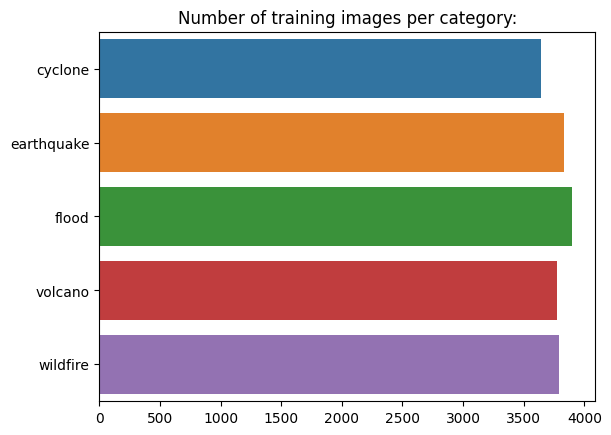

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
# Note that commets line are for here for old augmentations maybe not neccessary in future


test_vgg_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_vgg
                                   )
test_res_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_res
                                  )

In [13]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

test_vgg = test_vgg_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)
test_res = test_res_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 2540 images belonging to 5 classes.
Found 2540 images belonging to 5 classes.


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

# Ensamble 

## Predictions and Inspections

In [14]:
%cd /gdrive/MyDrive/bis_project

/gdrive/.shortcut-targets-by-id/1I7Sz2Z9huBbMrPdHrCzeiIFqOv3CkrpT/bis_project


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [16]:
# Load the different model

model1=load_model('resnet_.h5')
model2=load_model('ft_resnet.h5')
model3=load_model('tl_model_gap.h5')
model4=load_model('tlft13_model.h5')
model5=load_model('norm_gap_dense.h5')

In [17]:
# Initialize empty lists to store predictions from each model
probabilities_model1 = []
probabilities_model2 = []
probabilities_model3 = []
probabilities_model4 = []
probabilities_model5 = []

N = 2540
ground_truth_labels = test_vgg.classes

# Reset the generator to the beginning
test_vgg.reset()
test_res.reset()

In [18]:
# Do the predicton
predictions1 = model1.predict(test_res, steps=N//32+1)
predictions2 = model2.predict(test_res, steps=N//32+1)
predictions3 = model3.predict(test_vgg, steps=N//32+1)
predictions4 = model4.predict(test_vgg, steps=N//32+1)
predictions5 = model5.predict(test_vgg, steps=N//32+1)

# Save the predicted label
predicted_labels1 = np.argmax(predictions1, axis=1)
predicted_labels2 = np.argmax(predictions2, axis=1)
predicted_labels3 = np.argmax(predictions3, axis=1)
predicted_labels4 = np.argmax(predictions4, axis=1)
predicted_labels5 = np.argmax(predictions5, axis=1)

# Print classification report
classification_report1 = classification_report(ground_truth_labels, predicted_labels1)
print(f"Model 1 Classification Report:\n{classification_report1}")

classification_report2 = classification_report(ground_truth_labels, predicted_labels2)
print(f"Model 2 Classification Report:\n{classification_report2}")

classification_report3 = classification_report(ground_truth_labels, predicted_labels3)
print(f"Model 3 Classification Report:\n{classification_report3}")

classification_report4 = classification_report(ground_truth_labels, predicted_labels4)
print(f"Model 4 Classification Report:\n{classification_report4}")

classification_report5 = classification_report(ground_truth_labels, predicted_labels5)
print(f"Model 5 Classification Report:\n{classification_report5}")

80/80 [==============================] - 71s 849ms/step
Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       486
           1       0.94      0.94      0.94       517
           2       0.93      0.94      0.94       520
           3       0.96      0.96      0.96       509
           4       0.96      0.96      0.96       508

    accuracy                           0.94      2540
   macro avg       0.94      0.94      0.94      2540
weighted avg       0.94      0.94      0.94      2540

Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       486
           1       0.94      0.97      0.96       517
           2       0.95      0.94      0.95       520
           3       0.97      0.96      0.96       509
           4       0.94      0.97      0.96       508

    accuracy                           0.95      2540
   macro avg 

In [ ]:
# Calculate classification report
report1 = classification_report(ground_truth_labels, predicted_labels1, output_dict=True)
report2 = classification_report(ground_truth_labels, predicted_labels2, output_dict=True)
report3 = classification_report(ground_truth_labels, predicted_labels3, output_dict=True)
report4 = classification_report(ground_truth_labels, predicted_labels4, output_dict=True)
report5 = classification_report(ground_truth_labels, predicted_labels5, output_dict=True)

# Print performance for each class
classes = list(report1.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

for class_name in classes:
    print(f"Class: {class_name}")
    print(f"Model 1 - F1-score: {report1[class_name]['f1-score']}")
    print(f"Model 2 - F1-score: {report2[class_name]['f1-score']}")
    print(f"Model 3 - F1-score: {report3[class_name]['f1-score']}")
    print(f"Model 4 - F1-score: {report4[class_name]['f1-score']}")
    print(f"Model 5 - F1-score: {report5[class_name]['f1-score']}")
    print()

Class: 0
Model 1 - F1-score: 0.9039665970772442
Model 2 - F1-score: 0.9254984260230851
Model 3 - F1-score: 0.8494041170097507
Model 4 - F1-score: 0.911860718171926
Model 5 - F1-score: 0.891213389121339

Class: 1
Model 1 - F1-score: 0.9410628019323671
Model 2 - F1-score: 0.9551954242135366
Model 3 - F1-score: 0.923671497584541
Model 4 - F1-score: 0.947267497603068
Model 5 - F1-score: 0.9338446788111218

Class: 2
Model 1 - F1-score: 0.9360076408787009
Model 2 - F1-score: 0.9478764478764478
Model 3 - F1-score: 0.9121495327102804
Model 4 - F1-score: 0.9357798165137614
Model 5 - F1-score: 0.9300095877277085

Class: 3
Model 1 - F1-score: 0.9598432908912831
Model 2 - F1-score: 0.9625246548323472
Model 3 - F1-score: 0.9448209099709584
Model 4 - F1-score: 0.9521951219512195
Model 5 - F1-score: 0.9423459244532804

Class: 4
Model 1 - F1-score: 0.9617271835132483
Model 2 - F1-score: 0.9552529182879378
Model 3 - F1-score: 0.9499509322865555
Model 4 - F1-score: 0.9531405782652043
Model 5 - F1-score:

## Majority Vote

In [ ]:
ensemble_predictions = np.argmax(predictions1 + predictions2 + predictions3 + predictions4 + predictions5, axis=1)
majority_vote = np.argmax(np.bincount(ensemble_predictions))

# Print classification report
print("Ensemble Classification Report:")
print(classification_report(ground_truth_labels, ensemble_predictions))

# Print confusion matrix
print("Ensemble Confusion Matrix:")
print(confusion_matrix(ground_truth_labels, ensemble_predictions))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       486
           1       0.94      0.96      0.95       517
           2       0.94      0.97      0.95       520
           3       0.96      0.97      0.96       509
           4       0.96      0.97      0.96       508

    accuracy                           0.95      2540
   macro avg       0.95      0.95      0.95      2540
weighted avg       0.95      0.95      0.95      2540

Ensemble Confusion Matrix:
[[431  21  24   7   3]
 [ 12 497   6   1   1]
 [  7   7 502   1   3]
 [  0   0   2 495  12]
 [  2   2   0  13 491]]


## Weighted Voting

In [ ]:
# Define the weights for each model
weights = [0.2, 0.3, 0.1, 0.15, 0.25]

# Calculate weighted scores for each class
weighted_scores = np.zeros_like(predictions1)
models = [predictions1, predictions2, predictions3, predictions4, predictions5]

for i, model_pred in enumerate(models):
    weighted_scores += model_pred * weights[i]

# Get the predicted labels based on the highest cumulative weighted score
ensemble_predictions = np.argmax(weighted_scores, axis=1)


# Print classification report
print("Ensemble Classification Report:")
print(classification_report(ground_truth_labels, ensemble_predictions))

# Print confusion matrix
print("Ensemble Confusion Matrix:")
print(confusion_matrix(ground_truth_labels, ensemble_predictions))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       486
           1       0.95      0.97      0.96       517
           2       0.95      0.96      0.96       520
           3       0.97      0.97      0.97       509
           4       0.96      0.97      0.97       508

    accuracy                           0.96      2540
   macro avg       0.96      0.95      0.96      2540
weighted avg       0.96      0.96      0.96      2540

Ensemble Confusion Matrix:
[[438  20  20   5   3]
 [ 11 499   5   1   1]
 [  9   7 501   1   2]
 [  0   0   2 495  12]
 [  2   2   0  10 494]]


## Probability Averaging


In [ ]:
# Calculate average probabilities for each class
ensemble_probabilities = (predictions1 + predictions2 + predictions3 + predictions4 + predictions5) / 5.0

# Get the predicted labels based on the highest average probability
ensemble_predictions = np.argmax(ensemble_probabilities, axis=1)

In [ ]:
# Get the predicted labels based on the highest cumulative weighted score
ensemble_predictions = np.argmax(weighted_scores, axis=1)


# Print classification report
print("Ensemble Classification Report:")
print(classification_report(ground_truth_labels, ensemble_predictions))

# Print confusion matrix
print("Ensemble Confusion Matrix:")
print(confusion_matrix(ground_truth_labels, ensemble_predictions))

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       486
           1       0.94      0.96      0.95       517
           2       0.94      0.97      0.95       520
           3       0.96      0.97      0.97       509
           4       0.96      0.97      0.97       508

    accuracy                           0.95      2540
   macro avg       0.95      0.95      0.95      2540
weighted avg       0.95      0.95      0.95      2540

Ensemble Confusion Matrix:
[[432  20  25   6   3]
 [ 11 498   5   1   2]
 [  8   7 502   1   2]
 [  0   0   2 495  12]
 [  2   2   0  12 492]]
